In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import time
import os
from os import listdir
from os.path import isfile,join
from matplotlib import pyplot as mp
import numpy.matlib as npm

In [2]:
def kneeValue(y):
    values=y.copy()
    #get coordinates of all the points
    nPoints = len(values)
    allCoord = np.vstack((range(nPoints), values)).T
    #np.array([range(nPoints), values])

    # get the first point
    firstPoint = allCoord[0]
    # get vector between first and last point - this is the line
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))

    # find the distance from each point to the line:
    # vector between all points and first point
    vecFromFirst = allCoord - firstPoint

    # To calculate the distance to the line, we split vecFromFirst into two 
    # components, one that is parallel to the line and one that is perpendicular 
    # Then, we take the norm of the part that is perpendicular to the line and 
    # get the distance.
    # We find the vector parallel to the line by projecting vecFromFirst onto 
    # the line. The perpendicular vector is vecFromFirst - vecFromFirstParallel
    # We project vecFromFirst by taking the scalar product of the vector with 
    # the unit vector that points in the direction of the line (this gives us 
    # the length of the projection of vecFromFirst onto the line). If we 
    # multiply the scalar product by the unit vector, we have vecFromFirstParallel
    scalarProduct = np.sum(vecFromFirst * npm.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel

    # distance to line is the norm of vecToLine
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))

    # knee/elbow is the point with max distance value
    idxOfBestPoint = np.argmax(distToLine)

    #print ("Knee of the curve is at index =",idxOfBestPoint)
    #print ("Knee value =", values[idxOfBestPoint])
    return (values[idxOfBestPoint])

In [4]:
actualPredictionCsvFiles = ['SOL_yearwise.csv']

**************************************************
currentCsvLabelFile ::  SOL_yearwise.csv
currentCsvLabelFileFullPath ::  SOL_yearwise.csv
regressedDf.shape (641, 13)
currentIndicatorKey SOL
doubtfulPercent: 96.41185647425897
nonDoubtfulPercent: 3.58814352574103
positiveSlopeNonDoubtfulPercent 3.5881435257410295
zeroSlopeNonDoubtfulPercent 0.0
kneeStdErrValue 2317.6339809996903


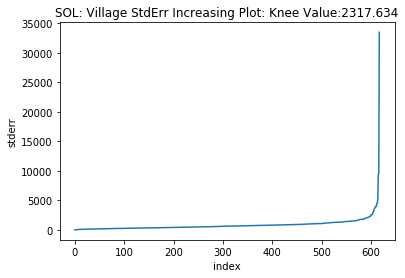

doubtfulDf_unsure_Percent 2.8081123244929795
doubtfulDf_sure_negative_Percent 19.65678627145086
doubtfulDf_sure_nonnegative_Percent 73.94695787831513
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$


In [5]:
doubtfulVillagesDictionary = {}
for currentCsvLabelFile in actualPredictionCsvFiles:
    print('*'*50)
    currentCsvLabelFileFullPath = currentCsvLabelFile
    print('currentCsvLabelFile :: ',currentCsvLabelFile)
    print('currentCsvLabelFileFullPath :: ',currentCsvLabelFileFullPath)
    df = pd.read_csv(currentCsvLabelFileFullPath)
    
    columnsPrediction=['SOL_14','SOL_15','SOL_16','SOL_17','SOL_18']
    subsetPredictionData=df[columnsPrediction]

    axisvalues=list(range(1,len(subsetPredictionData.columns)+1))
    def calc_slope(row):
        a = scipy.stats.linregress(axisvalues, y=row)
        return pd.Series(a._asdict())


    regressionData= (subsetPredictionData.apply(calc_slope,axis=1))
    regressedDf=pd.concat([df, regressionData], axis=1)
    print('regressedDf.shape',regressedDf.shape)
    
    underscoreStartIndex = currentCsvLabelFile.find('_')
    currentIndicatorKey = currentCsvLabelFile[:underscoreStartIndex].upper()
    print('currentIndicatorKey',currentIndicatorKey)
    
    
    
    diffValues=subsetPredictionData.diff(axis=1)
    diffValues=diffValues.drop(['SOL_14'],axis=1)
    doubtfulMask=[(np.any(zx<0)) for zx in diffValues.values]
    nonDoubtfulMask= [not av for av in doubtfulMask]
    totalVillages=len(doubtfulMask)
    doubtfulPercent = (np.sum(doubtfulMask)/totalVillages)*100
    nonDoubtfulPercent = (np.sum(nonDoubtfulMask)/totalVillages)*100
    print('doubtfulPercent:',doubtfulPercent)
    print('nonDoubtfulPercent:',nonDoubtfulPercent)
    positiveSlopeNonDoubtfulPercent = np.sum((regressedDf['slope'].values)[nonDoubtfulMask]>0)*100/totalVillages
    print('positiveSlopeNonDoubtfulPercent',positiveSlopeNonDoubtfulPercent)
    zeroSlopeNonDoubtfulPercent = np.sum((regressedDf['slope'].values)[nonDoubtfulMask]==0)*100/totalVillages
    print('zeroSlopeNonDoubtfulPercent',zeroSlopeNonDoubtfulPercent)
    # print(stdErrOfDoubtfulVillages.shape)
    positiveMask=regressedDf['slope']>0
    negativeMask=regressedDf['slope']<0
    positiveDoubtfulMask = doubtfulMask & positiveMask
    negativeDoubtfulMask = doubtfulMask & negativeMask
    regressedDf['doubtfulMask'] = doubtfulMask
    
    
    
    plt.clf()
    stdErrOfDoubtfulVillages=(regressedDf)['stderr'].values[doubtfulMask]
    y = stdErrOfDoubtfulVillages.tolist()
    x = list(range(len(y)))
    y.sort() 
    plt.plot(x, y)
    kneeVal=kneeValue(y)
    print("kneeStdErrValue",kneeVal)
    plt.title(currentIndicatorKey+": Village StdErr Increasing Plot: Knee Value:"+str(round(kneeVal,3)))
    plt.ylabel('stderr')
    plt.xlabel('index')
    plt.show()
    doubtfulDf = regressedDf[doubtfulMask].copy()
    doubtfulDf_unsure = doubtfulDf[doubtfulDf['stderr']>kneeVal]
    doubtfulDf_sure = doubtfulDf[doubtfulDf['stderr']<=kneeVal]
    doubtfulDf_sure_negative = doubtfulDf_sure[doubtfulDf_sure['slope']<0]
    doubtfulDf_sure_postive = doubtfulDf_sure[doubtfulDf_sure['slope']>=0]
    
    unsureMask = regressedDf['stderr']>kneeVal
    unsureDoubtfulMask = unsureMask & doubtfulMask
    regressedDf['unsureDoubtfulMask'] = unsureDoubtfulMask
    sureMask = regressedDf['stderr']<=kneeVal
    sureDoubtfulMask = sureMask & doubtfulMask
    sureDoubtfulNegativeMask = negativeMask & sureDoubtfulMask
    
    regressedDf['sureDoubtfulNegativeMask'] = sureDoubtfulNegativeMask
    regressedDf['unsureDoubtfulMask'] = unsureDoubtfulMask
    
    
    #df.somecolumn = df.somecolumn.astype(int)
    regressedDf.doubtfulMask=regressedDf.doubtfulMask.astype(int)
    regressedDf.unsureDoubtfulMask=regressedDf.unsureDoubtfulMask.astype(int)
    regressedDf.sureDoubtfulNegativeMask=regressedDf.sureDoubtfulNegativeMask.astype(int)
    regressedDf.to_csv(currentCsvLabelFileFullPath[:-4]+'_RegressedData.tsv',sep='\t',index=False)
    print("doubtfulDf_unsure_Percent",(doubtfulDf_unsure.shape[0]*100/totalVillages))
    print("doubtfulDf_sure_negative_Percent",(doubtfulDf_sure_negative.shape[0]*100/totalVillages))
    print("doubtfulDf_sure_nonnegative_Percent",(doubtfulDf_sure_postive.shape[0]*100/totalVillages))
    print("$"*50)